In [64]:
import numpy as np 
import pandas as pd 
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import cross_validate
from sklearn.cross_validation import KFold
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [33]:
data = np.load('data.npy')
cat_labels = np.load('cat_labels.npy')
data = data.astype('float32')
data /= 255

In [55]:
batch_size = 128
num_classes = 103
epochs = 50
img_rows, img_cols, dim = 64, 64, 3
input_shape = (img_rows, img_cols, dim)
nfolds = 5

### Train Test split to facilitate evaluation of generalization performance

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, cat_labels, test_size = 0.2)

In [36]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model

In [37]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(self.model.evaluate(xva, yva, verbose=0)[0])

### Cross validation to find the best number of epochs for model. We can use it to tune other hyperparameters too

In [63]:
folds = KFold(len(y_train), n_folds = nfolds, shuffle = True, random_state = 111)
vallogger = []
trlogger = []
tracc = []
valacc = []
for num, (inTr, inVa) in enumerate(folds):
    xtr = X_train[inTr]
    xva = X_train[inVa]
    ytr = y_train[inTr]
    yva = y_train[inVa]
    model = create_model()
    history = model.fit(xtr, ytr, batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data = (xva, yva))
    vallogger.append(history.history['val_loss'])
    trlogger.append(history.history['loss'])
    tracc.append(history.history['acc'])
    valacc.append(history.history['val_acc'])
    print('Done fold ' + str(num))
    
vallogger = np.array(vallogger)
trlogger = np.array(trlogger)
valacc = np.array(valacc)
tracc = np.array(tracc)

Done fold 0
Done fold 1
Done fold 2
Done fold 3
Done fold 4


In [67]:
val_acc, val_loss, tr_acc, tr_loss = [], [], [], []
for j in range(epochs):
    acc, loss, val_ac, val_l = 0, 0, 0, 0
    for i in range(nfolds):
        acc += tracc[i][j]
        loss += trlogger[i][j]
        val_ac += vallogger[i][j]
        val_l += valacc[i][j]
    val_acc.append(1.0*val_ac/nfolds)
    val_loss.append(1.0*val_l/nfolds)
    tr_acc.append(1.0*acc/nfolds)
    tr_loss.append(1.0*loss/nfolds)
    
        

In [68]:
import matplotlib.pyplot as plt

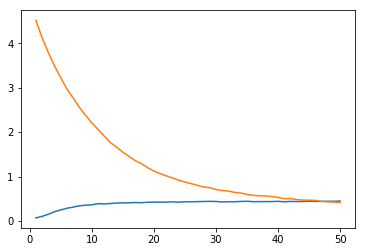

In [70]:
plt.plot(range(1, epochs + 1), val_loss)
plt.plot(range(1, epochs + 1), tr_loss)

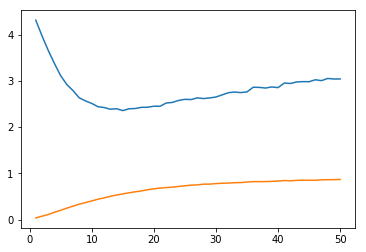

In [71]:
plt.plot(range(1, epochs + 1), val_acc)
plt.plot(range(1, epochs + 1), tr_acc)

### Seeing from the above graphs, epoch 15 is the best non-overfitting model

### Retraining the model on whole training data with ideal epochs found and evaluating

In [72]:
model = create_model()
model.fit(X_train, y_train, batch_size=batch_size,
          epochs=15,
          verbose=0)

In [73]:
print(model.evaluate(X_test, y_test, verbose=0))

[2.172911012274587, 0.4401709401891345]


### Adding Data augmentation and ensemble method such as boosting wont have much of an impact. Thus, conventional CNN are not enough to deal with such small data problem

### Thus, we need to deal with this problem using Transfer Learning and Fine Tuning